# Process Data

## Imports and Setup

In [1]:

# Import necessary modules
import matplotlib.pyplot as plt
import pandas as pd
import json


In [2]:

# Load data
with open('../data/chainmail_data.json', mode='r') as json_file:
    data = json.load(json_file)


In [3]:

# Convert data into a pandas DataFrame and show sample values
df = pd.DataFrame(data).transpose()
df.head()


,Articles,Date Uploaded,Ideal AR,Last Edited,Max AR,Min AR,Tags,Weave Title
1,{'Weave Tutorials': ['Trizantine (CGI)']},"May 3, 2008, 6:36 pm",5.2,"June 22, 2017, 11:45 am",,,"[European, Chain, Progression, Alpha]",Trizantine
2,{'Weave Tutorials': ['Hizashi Subfamily']},"December 28, 2008, 7:41 pm",8.0|3.0,"August 2, 2011, 7:13 pm",,,"[Japanese, Sheet, Radial, Modification]",Hizashi 1
3,{'Weave Tutorials': ['Hizashi Subfamily']},"December 28, 2008, 7:42 pm",6.0|3.5,"August 2, 2011, 7:13 pm",,,"[Japanese, Sheet, Radial, Modification]",Hizashi 3
4,None,"November 8, 2002, 2:37 am",7.3|3.0,"August 2, 2011, 7:37 pm",,,"[Japanese, Sheet, Progression, Alpha]",Japanese 5 in 1 (3.3.4.3.4)
5,None,"April 15, 2004, 5:29 am",5.5|3.3,"August 2, 2011, 7:18 pm",,,"[Japanese, Sheet, Orbital, Modification]",Interlock


## Clean Up Data

### Remove Invalid Values

In [4]:

# Remove null-articles
null_records = df['Weave Title'].isnull()
df = df[~null_records]

# Replace an unexpected bad value with an empty string
df.replace(to_replace={"AR'sShownareinMultipleWireSizes,seeWeaveDescriptionfordetails.": ''}, inplace=True)


### Clean Up Dates

In [5]:

# Convert date columns to datetime format
df['Date Uploaded'] = pd.to_datetime(df['Date Uploaded'], format="mixed")
df['Last Edited'] = pd.to_datetime(df['Last Edited'], format='mixed', dayfirst=True)


### Construct Article Values

In [6]:
# Determine how many article types exist

types = set()

for i in df['Articles'].values:
    if i:
        types.update(i.keys())

types



{'Other Related Articles', 'Weave Tutorials'}

In [7]:

# Write helper function that counts the number of articles
def count_articles(d: dict) -> int:
    if not d:
        return 0
    
    out = 0
    for key, value in d.items():
        out += len(value)
    return out


# Write helper function that counts the number of tutorials
def count_tutorials(d: dict) -> int:
    if not d:
        return 0
    
    return len(d.get('Weave Tutorials', list()))


# Create a column that contains the number of articles the record has
df['Num Articles'] = df['Articles'].apply(count_articles)

# Create a column that contains the number tutorials the record has
df['Num Tutorials'] = df['Articles'].apply(count_tutorials)

# This does the same thing but is more complex
# df['Articles'].apply(lambda d : len(d.get('Weave Tutorials', list())) if d else 0)


### Handle AR Values

**Create Helper Columns**

In [8]:

# Create a column denoting if the record has an AR value
ideal_empty = (df['Ideal AR'] == '')
min_empty = (df['Min AR'] == '')
max_empty = (df['Max AR'] == '')

df['Has AR Value'] = (~(ideal_empty & min_empty & max_empty))


# Create a column denoting if the record has multiple AR values
multi_ideal = df['Ideal AR'].str.contains('\|')
multi_min = df['Min AR'].str.contains('\|')
multi_max = df['Max AR'].str.contains('\|')

df['Has Multiple AR Values'] = (multi_ideal | multi_min | multi_max)


**Find Values of Interest**

In [9]:

# Count number weaves with no AR values provided
noAR = len(df[~df['Has AR Value']])
print(f"{noAR}/{len(df)} weaves have no listed AR Values")

# Of The weaves with AR values how many don't have Ideal AR values
noIdeal = len(df[ideal_empty * df['Has AR Value']])
withAR = len(df[df['Has AR Value']])
print(f"{noIdeal} weaves of the {withAR} weaves with at least one AR value are missing their Ideal AR")

# Investigate cases with no Ideal AR that have a Max AR
noIdealMax = len(df[ideal_empty & ~max_empty])
print(f"Number of weaves with no Ideal AR that have a Max AR: {noIdealMax}")

#  Investigate cases with no Ideal AR that have a Min AR
noIdealMin = len(df[ideal_empty & ~min_empty])
print(f"Number of weaves with no Ideal AR that have a Min AR: {noIdealMin}")


38/1456 weaves have no listed AR Values
15 weaves of the 1418 weaves with at least one AR value are missing their Ideal AR
Number of weaves with no Ideal AR that have a Max AR: 0
Number of weaves with no Ideal AR that have a Min AR: 15


**Create Additional DataFrames For Analysis**

In [10]:

# Initialize empty list 
ar_vals = list()

# Turn weave record into appropriate rows for ar_df
def test(record: pd.core.series.Series) -> None:
    if record['Has AR Value']:
        # Chose a single AR value to represent the weave - using Min AR as fallback due to earlier exploration
        ideal_ar = record['Ideal AR']
        min_ar = record['Min AR']
        ar_val = ideal_ar if ideal_ar != '' else min_ar

        # clean up AR value string
        ar_val = ar_val.replace('..', '.')
        ar_val = ar_val.replace('?', '')

        # Get Values of interest
        tutorials = record['Num Tutorials']
        multi_ar = record['Has Multiple AR Values']

        # Add AR values to 
        for val in ar_val.split('|'):
            if val:
                row = {
                    'AR': float(val),
                    'tutorials': (tutorials > 0),
                    'multi_ar': multi_ar,
                }

                ar_vals.append(row)

# Iterate through df to create data for AR DataFrame
_ = df.apply(test, axis=1)

# Create and display AR Data Frame
ar_df = pd.DataFrame(ar_vals)
ar_df.head()


,AR,tutorials,multi_ar
0,5.2,True,False
1,8.0,True,True
2,3.0,True,True
3,6.0,True,True
4,3.5,True,True


## Answer Questions And Create Graphs

### What Are The Most Common Aspect Ratios

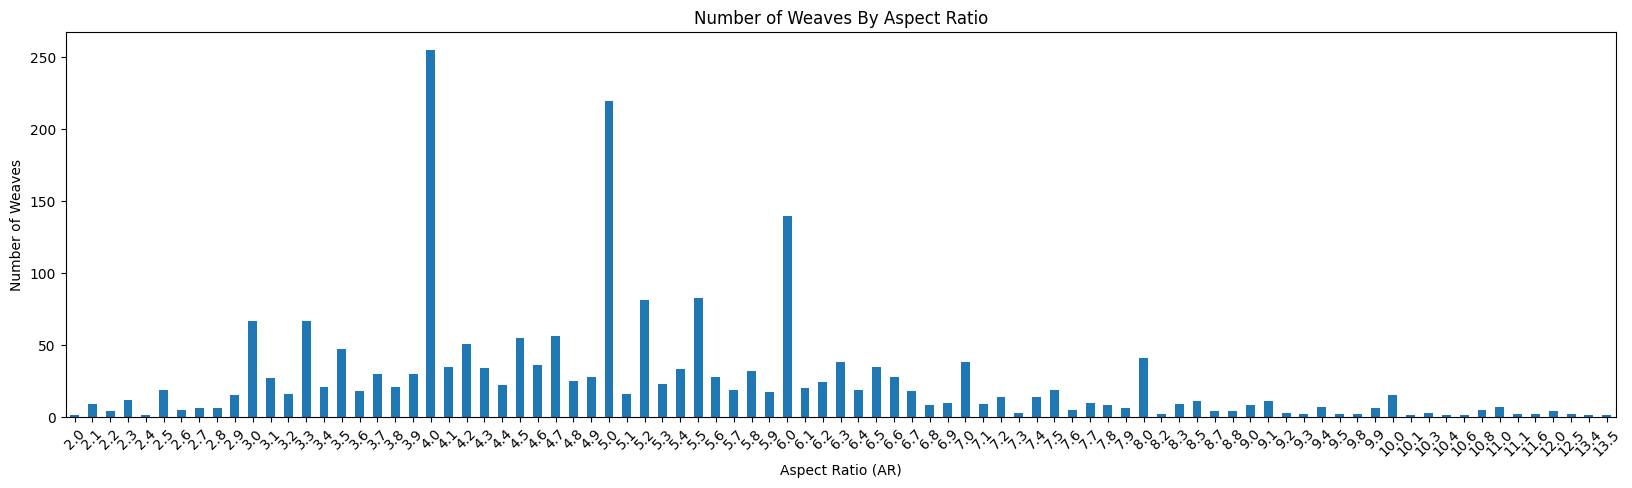

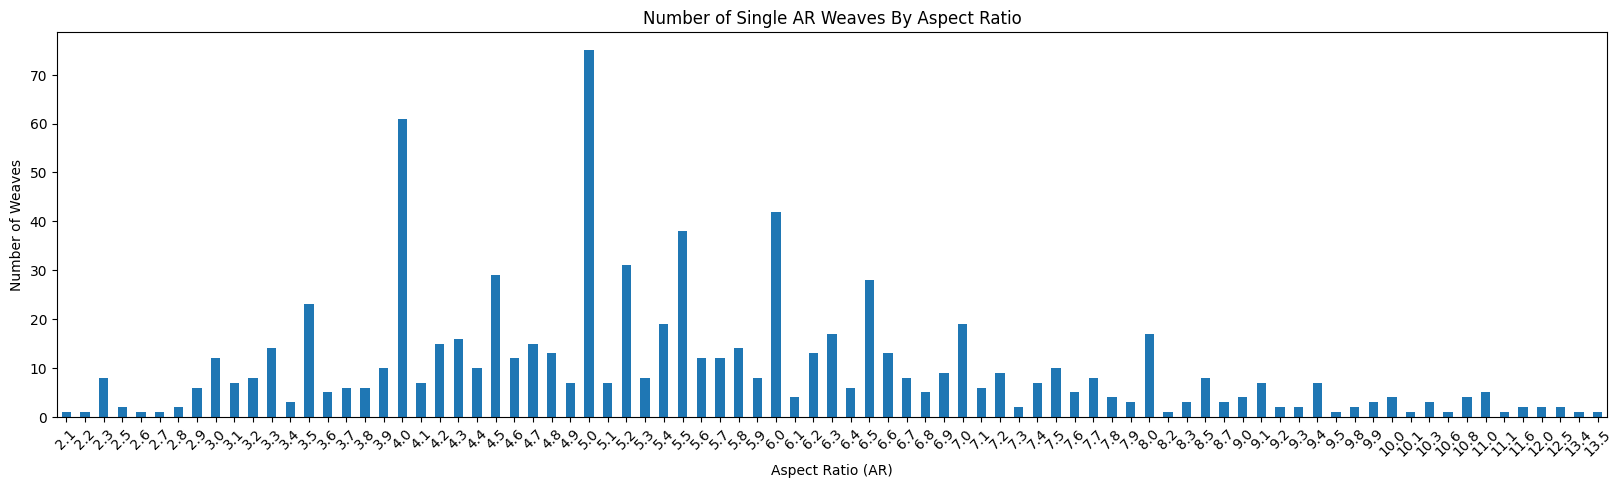

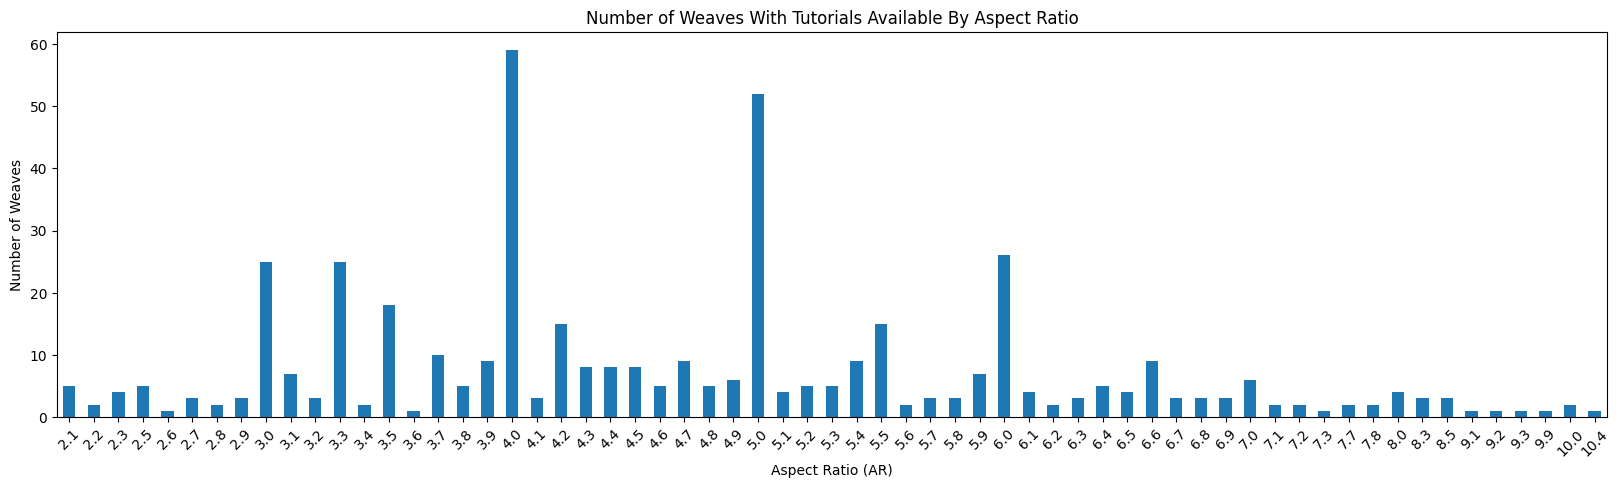

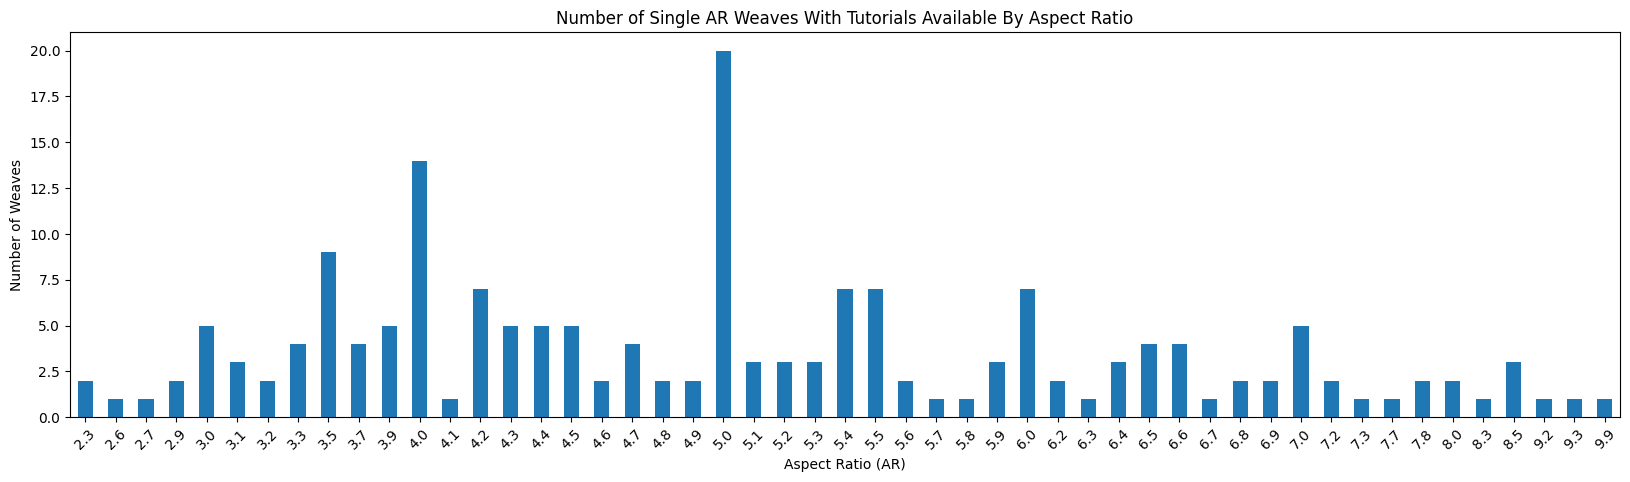

In [11]:

### No Restrictions
un_restricted = ar_df[['AR', 'tutorials']].groupby('AR').agg('count').reset_index()
_ = un_restricted.plot(
    kind='bar', 
    x='AR', 
    y='tutorials',
    xlabel='Aspect Ratio (AR)',
    ylabel='Number of Weaves',
    title='Number of Weaves By Aspect Ratio',
    figsize=(20,5),
    legend=False,
    rot=45,
)

### Only Single AR
singleAR = ar_df[~ar_df['multi_ar']][['AR', 'tutorials']].groupby('AR').agg('count').reset_index()
_ = singleAR.plot(
    kind='bar',
    x='AR',
    y='tutorials',
    xlabel='Aspect Ratio (AR)',
    ylabel='Number of Weaves',
    title='Number of Single AR Weaves By Aspect Ratio',
    figsize=(20,5),
    legend=False,
    rot=45,
)

### Has Tutorials
hasTutorials = ar_df[ar_df['tutorials']][['AR', 'tutorials']].groupby('AR').agg('count').reset_index()
_ = hasTutorials.plot(
    kind='bar',
    x='AR',
    y='tutorials',
    xlabel='Aspect Ratio (AR)',
    ylabel='Number of Weaves',
    title='Number of Weaves With Tutorials Available By Aspect Ratio',
    figsize=(20,5),
    legend=False,
    rot=45,
)

### Single AR with tutorials only
singleARWithTutorials = ar_df[ar_df['tutorials'] & ~ar_df['multi_ar']][['AR', 'tutorials']].groupby('AR').agg('count').reset_index()
_ = singleARWithTutorials.plot(
    kind='bar',
    x='AR',
    y='tutorials',
    xlabel='Aspect Ratio (AR)',
    ylabel='Number of Weaves',
    title='Number of Single AR Weaves With Tutorials Available By Aspect Ratio',
    figsize=(20,5),
    legend=False,
    rot=45,
)

### Most popular AR pairs


### What Are The Most Popular Tags

In [12]:

### 10 most popular weaves

### See if it may be possible to do this as a time series


### How Many Weaves Came Out Over Time

Looking at the graphs below it shows that aside from a dip in weave submissions in 2007 M.A.I.L. was receiving it highest yearly submissions from 2006 to 2010. Looking at the monthly data there is one large outlier in November 2006 where 95 weaves were submitted that month.

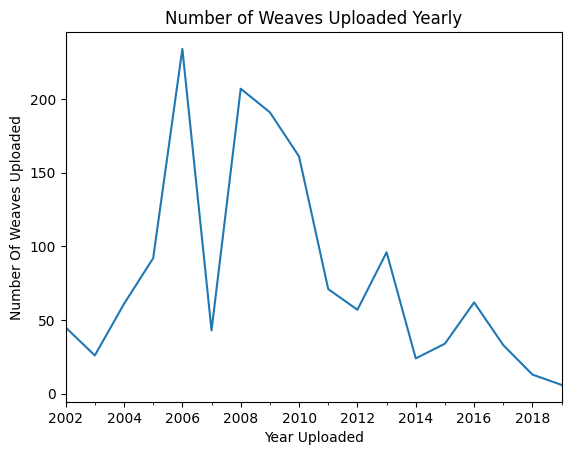

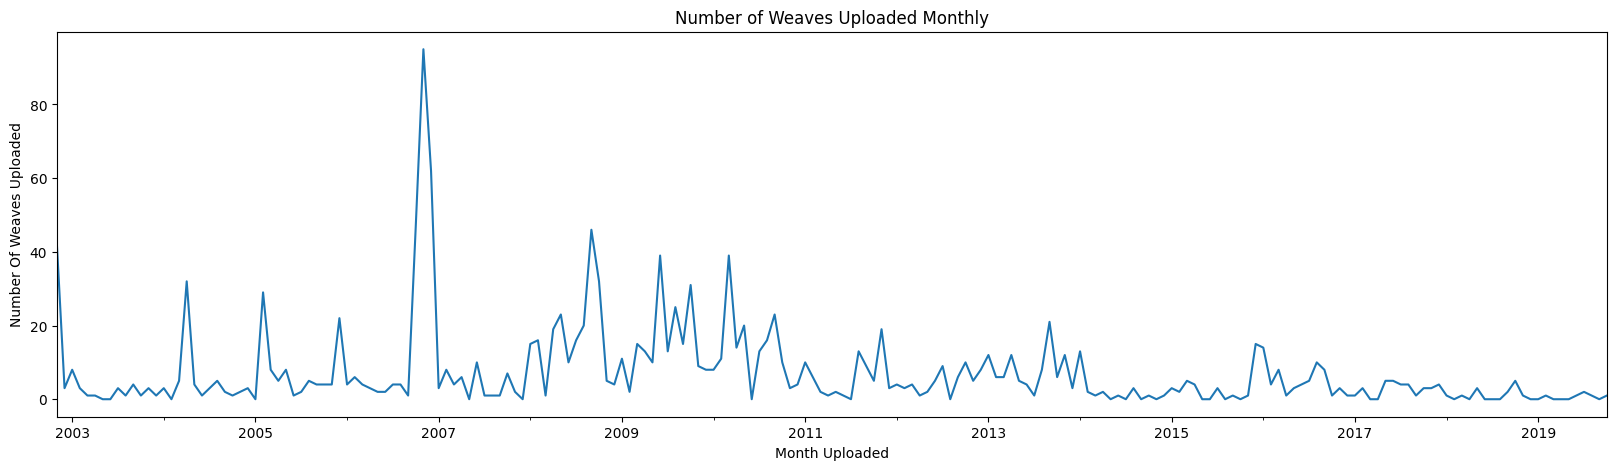

In [13]:

yearly_data = df[['Weave Title', 'Date Uploaded']].groupby(pd.Grouper(key='Date Uploaded', freq='Y')).agg('count').reset_index()
_ = yearly_data.plot(
    kind='line', 
    x='Date Uploaded', 
    y='Weave Title', 
    xlabel='Year Uploaded', 
    ylabel='Number Of Weaves Uploaded', 
    title='Number of Weaves Uploaded Yearly', 
    legend=False
)


monthly_data = df[['Weave Title', 'Date Uploaded']].groupby(pd.Grouper(key='Date Uploaded', freq='M')).agg('count').reset_index()
_ = monthly_data.plot(
    kind='line', 
    x='Date Uploaded', 
    y='Weave Title', 
    xlabel='Month Uploaded', 
    ylabel='Number Of Weaves Uploaded', 
    title='Number of Weaves Uploaded Monthly', 
    legend=False,
    figsize=(20,5)
)
